In [1]:
import yfinance as yf
ora = yf.Ticker("ORA.PA")
print(ora.info)

{'zip': '92130', 'sector': 'Communication Services', 'fullTimeEmployees': 139698, 'longBusinessSummary': 'Orange S.A. provides various fixed telephony and mobile telecommunications, data transmission, and other value-added services to customers, businesses, and other telecommunications operators in France and internationally. It operates through France; Spain and Other European Countries; The Africa and Middle East; Enterprise; International Carriers & Shared Services; and Mobile Financial Services segments.  The company offers mobile services, such as voice, SMS, and data; fixed broadband and narrowband services, as well as fixed network business solutions, including voice and data; and convergence packages. It also sells mobile handsets, mobile terminals, broadband equipment, connected devices, and accessories. In addition, the company provides IT and integration services comprising unified communication and collaboration services, such as LAN and telephony, consultancy, integration,

In [2]:
ora

yfinance.Ticker object <ORA.PA>

In [35]:
import numpy as np
import datetime as dt
import pandas as pd
import importlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import matplotlib.gridspec as gridspec
%matplotlib inline
import statsmodels.api as sm
import scipy.stats as ss
from scipy.optimize import minimize
from IPython import display
from scipy.linalg import inv
import filterpy.kalman as kf

In [78]:
ora_historical= yf.download("ORA.PA ^FCHI", start="2020-01-01",end="2022-07-31",interval="1d")

[*********************100%***********************]  2 of 2 completed


In [79]:
ora_historical[ora_historical.isna().any(axis=1)].tail()

Empty DataFrame
Columns: [(Adj Close, ORA.PA), (Adj Close, ^FCHI), (Close, ORA.PA), (Close, ^FCHI), (High, ORA.PA), (High, ^FCHI), (Low, ORA.PA), (Low, ^FCHI), (Open, ORA.PA), (Open, ^FCHI), (Volume, ORA.PA), (Volume, ^FCHI)]
Index: []

In [80]:
(ora_historical < 1e-2 ).any()

Adj Close  ORA.PA    False
           ^FCHI     False
Close      ORA.PA    False
           ^FCHI     False
High       ORA.PA    False
           ^FCHI     False
Low        ORA.PA    False
           ^FCHI     False
Open       ORA.PA    False
           ^FCHI     False
Volume     ORA.PA    False
           ^FCHI      True
dtype: bool

In [81]:
df = ora_historical[ ["Close"] ]

In [82]:
df = df.dropna(axis=0, how='all')

In [83]:
print("Are there still some NaNs? "); df.isnull().any()

Are there still some NaNs? 


Close  ORA.PA    False
       ^FCHI     False
dtype: bool

In [84]:
returns = "log-returns"

if returns=="log-returns":
    ret = np.log( df/df.shift() )[1:]
elif returns=="linear-returns":  
    ret = df.pct_change()[1:]
elif returns=="total-returns":
    ret = df/df.shift()[1:]

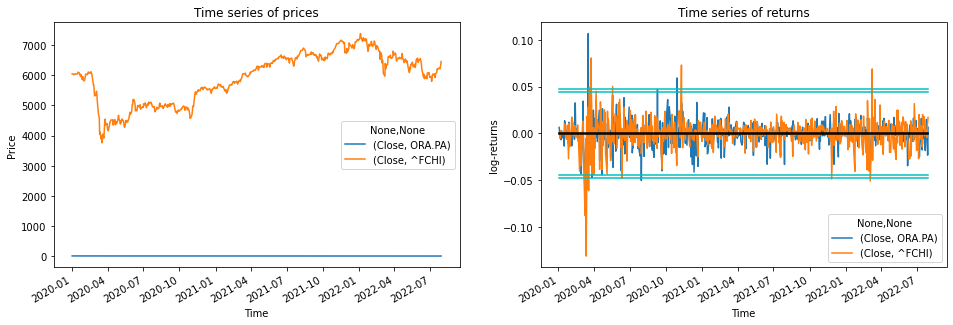

In [85]:
NOSD = 3               # Number Of Standard Deviations
mu = ret.mean()
sig = ret.std()
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

df.plot(ax=ax1)
ax1.set_title("Time series of prices"); ax1.set_xlabel("Time"); ax1.set_ylabel("Price")
ret.plot(ax=ax2)
ax2.set_title("Time series of returns"); ax2.set_xlabel("Time"); ax2.set_ylabel(returns)
ax2.plot(ret.index, len(ret)*[mu], color="k" )
ax2.plot(ret.index, len(ret)*[mu+NOSD*sig], color='c' )
ax2.plot(ret.index, len(ret)*[mu-NOSD*sig], color='c' )
plt.show()

In [86]:
median = ret.median()
MAD = ret.mad()
sig_robust = MAD*1.4826
print("STD DEV: \n", sig); print(""); print("Robust STD DEV: \n", sig_robust); 

STD DEV: 
 Close  ORA.PA    0.014728
       ^FCHI     0.015862
dtype: float64

Robust STD DEV: 
 Close  ORA.PA    0.014547
       ^FCHI     0.015380
dtype: float64


In [87]:
outliers = ret[ret[ np.abs(ret-median)>NOSD*sig_robust ].any(axis=1)]     # outliers
dret = ret.drop(outliers.index)                                           # series of returns without outliers


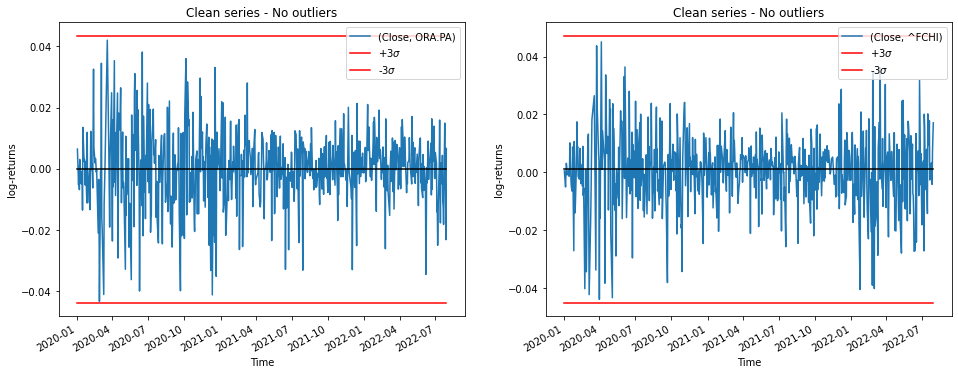

In [88]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122) 

for ax, col in zip([ax1,ax2], dret.columns):
    dret[col].plot(ax=ax)
    ax.set_title("Clean series - No outliers"); ax.set_xlabel("Time"); ax.set_ylabel(returns)
    ax.plot(dret.index, len(dret)*[median[col]], color="k" )
    ax.plot(dret.index, len(dret)*[median[col]+NOSD*sig_robust[col]], color='r', label="+3$\sigma$" )
    ax.plot(dret.index, len(dret)*[median[col]-NOSD*sig_robust[col]], color='r', label="-3$\sigma$" )
    ax.legend(loc="upper right")
plt.show()


In [89]:
print("We have reduced the initial DIRTY series of returns of size {} to the \
new CLEAN series of size {}.".format(len(ret),len(dret)))

We have reduced the initial DIRTY series of returns of size 662 to the new CLEAN series of size 644.


In [90]:
X = dret[dret.columns[1]]
Y = dret[dret.columns[0]]
print("In our regression Y is {} and X is {}".format(dret.columns[0],dret.columns[1]) )

In our regression Y is ('Close', 'ORA.PA') and X is ('Close', '^FCHI')


In [91]:
b_ss, a_ss, r_ss, _, std_err_ss = ss.linregress(X,Y)
print("We can use one of the many python functions:\nbeta: {0:6f}, alpha: {1:6f}, R2: {2:6f}, \
standard error: {3:6f}.".format(b_ss, a_ss, r_ss**2, std_err_ss))

beta_tot_OLS = np.cov(X,Y,ddof=1)[0,1] / np.var(X,ddof=1)
alpha_tot_OLS = np.mean(Y) - beta_tot_OLS * np.mean(X)
res = Y - beta_tot_OLS * X - alpha_tot_OLS
std_eps_OLS = np.std(res, ddof=2) 
print("\nOr I can estimate by myself:\nbeta: {}, alpha: {}, sigma: {}".format(beta_tot_OLS, 
                                                                             alpha_tot_OLS, std_eps_OLS))

We can use one of the many python functions:
beta: 0.390222, alpha: -0.000494, R2: 0.162883, standard error: 0.034914.

Or I can estimate by myself:
beta: 0.3902217132753639, alpha: -0.0004938023099485765, sigma: 0.011070796673441545


In [92]:
n = len(X)
x_mean = np.mean(X); y_mean = np.mean(Y)
Sxx = (X-x_mean) @ (X-x_mean)
Syy = (Y-y_mean) @ (Y-y_mean)
Sxy = (X-x_mean) @ (Y-y_mean)
beta_hat = Sxy/Sxx; alpha_hat = y_mean - beta_hat * x_mean    # beta and alpha
print("beta: {} and alpha: {}".format(beta_hat,alpha_hat))
epsilon = Y - beta_hat * X - alpha_hat             # residuals
S2 = epsilon @ epsilon / (n-2); S = np.sqrt(S2)    # unbiased estimator
print("sigma: {}".format(S))
var_beta = S2/Sxx                 # variance of beta 
var_alpha = (X@X) * S2/(Sxx * n)  # variance of alpha 
s_b = np.sqrt(var_beta)           # standard error for beta
s_a = np.sqrt(var_alpha)          # standard error for alpha
R2 = Sxy**2 / (Sxx*Syy)           
print("Standard Error for beta: ", s_b); print("R squared: {}".format(R2))
CI_b = ss.t.interval(0.95, n-2, loc=beta_hat, scale=s_b );  b_up = CI_b[0]; b_down = CI_b[1]
CI_a = ss.t.interval(0.95, n-2, loc=alpha_hat, scale=s_a )
print("Confidence intervals for beta: ", CI_b); print("Confidence intervals for alpha: ", CI_a)

beta: 0.3902217132753632 and alpha: -0.0004938023099485761
sigma: 0.01107079667344155
Standard Error for beta:  0.034914017518669856
R squared: 0.16288255594487447
Confidence intervals for beta:  (0.32166224524216136, 0.45878118130856504)
Confidence intervals for alpha:  (-0.0013510168995863267, 0.0003634122796891744)


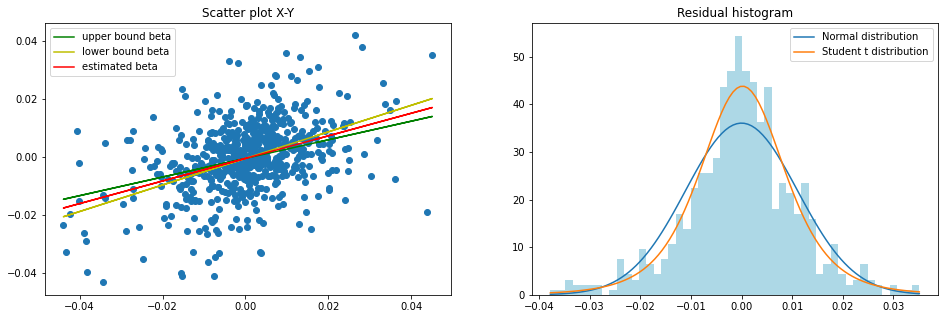

In [93]:
x = np.linspace(res.min(),res.max(),100)     # res are the residuals

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
ax1.scatter(X, Y); ax1.set_title("Scatter plot X-Y") 
ax1.plot(X, alpha_hat + b_up*X, color="g", label="upper bound beta")
ax1.plot(X, alpha_hat + b_down*X, color="y", label="lower bound beta")
ax1.plot(X, alpha_hat + beta_hat*X, color="red", label="estimated beta"); ax1.legend(loc="upper left")
ax2.plot(x, ss.norm.pdf(x,0,S), label="Normal distribution")
params = ss.t.fit(res)
ax2.plot(x, ss.t.pdf(x, loc=params[1], scale=params[2], df=params[0]), label="Student t distribution")
ax2.hist(res, bins=50, density=True, facecolor="LightBlue") 
ax2.legend(); ax2.set_title("Residual histogram"); plt.show()

In [94]:
print("Degrees of freedom of fitted t distribution: ", params[0])

Degrees of freedom of fitted t distribution:  4.6966951740486635


In [97]:
Y = dret.columns[0]
X = dret.columns[1]

In [98]:
training_size = 250
ret_train = dret.iloc[:training_size] 
ret_test = dret.iloc[training_size:] 


In [99]:
beta_tr, alpha_tr, _ ,_ ,_  = ss.linregress(ret_train[X], ret_train[Y])
resid_tr = ret_train[Y] - beta_tr * ret_train[X] - alpha_tr
var_eps_ols = resid_tr.var(ddof=2)                       # a possible initial guess for var_eps
print("In the training set the OLS estimators of") 
print("alpha_tr = ", alpha_tr); print("beta_tr = ", beta_tr); print("var_eps = ", var_eps_ols) 

In the training set the OLS estimators of
alpha_tr =  -0.001286093904015239
beta_tr =  0.6053693647609079
var_eps =  0.00016690670965124833


In [100]:
rolling_window = 50
rolling_beta = []
rolling_std_err = []
rolling_alpha = []

for i in range( len(ret_test) ):
    ret_temp = ret.iloc[ 1+i+training_size-rolling_window : 1+i+training_size ]
    beta_temp, alpha_temp , _ ,_ , std_err_temp  = ss.linregress(ret_temp[X],ret_temp[Y])
    rolling_beta.append(beta_temp)
    rolling_std_err.append(std_err_temp)
    rolling_alpha.append(alpha_temp)
ret_test = ret_test.assign(ols_beta=np.array(rolling_beta))
ret_test = ret_test.assign(ols_std_err=np.array(rolling_std_err))
ret_test = ret_test.assign(ols_alpha=np.array(rolling_alpha))

In [101]:
x = np.array([[alpha_tr],[beta_tr]])        # initial mean of alpha and beta
P = 0.1 * np.eye(2)                         # initial covariance of alpha and beta
eta_alpha = 0.0000001                       # variance of the alpha process 
eta_beta = 0.01                             # variance of the beta process
Q = np.diag([eta_alpha, eta_beta])          # process covariance matrix 
R = np.array([[var_eps_ols]])               # variance for the measurement - 1 dim 
F = np.eye(2)                               # transition matrix
H = np.vstack( (np.ones(len(ret_test)), ret_test[X].values) ).T                 # measurement matrix


In [102]:
alphas, betas = np.full( len(ret_test), np.NaN ), np.full( len(ret_test), np.NaN )
for i,y in enumerate(ret_test[Y]):
    # predict
    x = F @ x
    P = (F @ P @ F.T) + Q
    
    #update
    S = (H[None,i] @ P @ H[None,i].T) + R     # Here S is a scalar
    K = (P @ H[None,i].T) @ inv(S)             
    r = y - H[None,i]@x                       # residuals
    x = x + K @ r                             # v is a scalar. 
    P = P - K @ H[None,i] @ P                 # K @ H[None,i] is an outer product
    
    alphas[i] = x[0]; betas[i] = x[1]


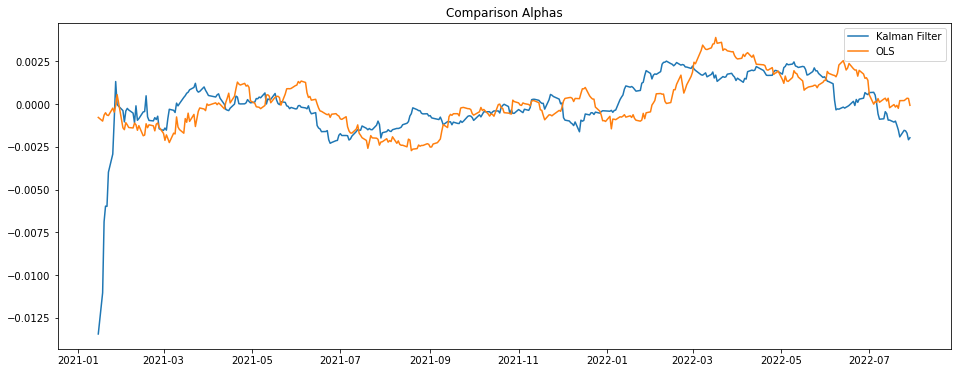

In [103]:
plt.figure(figsize=(16,6))
plt.plot( ret_test.index, alphas, label="Kalman Filter")
plt.plot( ret_test["ols_alpha"], label="OLS" )
plt.legend(); plt.title("Comparison Alphas"); plt.show()

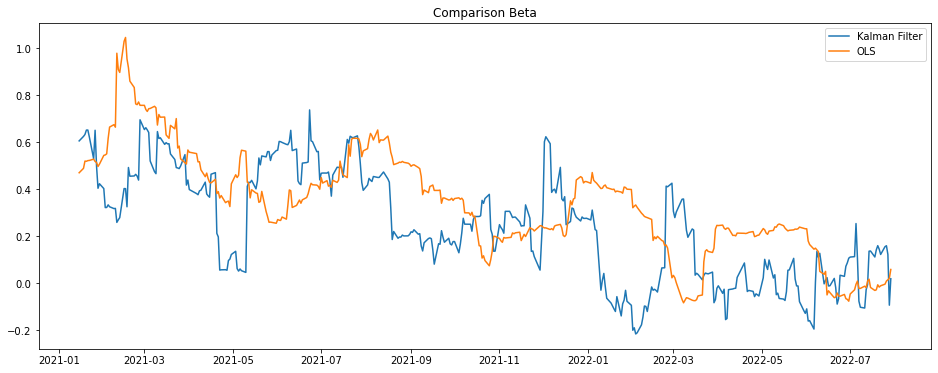

In [104]:
plt.figure(figsize=(16,6))
plt.plot( ret_test.index, betas, label="Kalman Filter")
plt.plot( ret_test["ols_beta"], label="OLS" )
plt.legend(); plt.title("Comparison Beta"); plt.show()

In [125]:
import sys  
sys.path.insert(0, '/home/parallels/dev/20-PYTHON-PROG/KalmanTraining')

In [127]:
import Kalman_filter

In [129]:
import Kalman_filter as KF

In [130]:
KR = KF.Kalman_regression(ret_train[X], ret_train[Y])

alpha0, beta0 and var_eps initialized by OLS


In [131]:
dimens = 40
var_eps_x = np.linspace(1e-5,2e-4,dimens)
var_eta_y = np.linspace(1e-5,2e-4,dimens)
X_grid, Y_grid = np.meshgrid(var_eps_x, var_eta_y)
V_grid = np.ones((dimens,dimens))

for i, i_eps in enumerate(var_eps_x):
    for j, j_eta in enumerate(var_eta_y):
        KR.var_eps = i_eps
        KR.var_eta = j_eta
        KR.run()
        V_grid[j,i] = KR.loglikelihood

KR.set_OLS_params()
V = np.ones(dimens)        
for j, j_eta in enumerate(var_eta_y):
    KR.var_eta = j_eta
    KR.run()
    V[j] = KR.loglikelihood

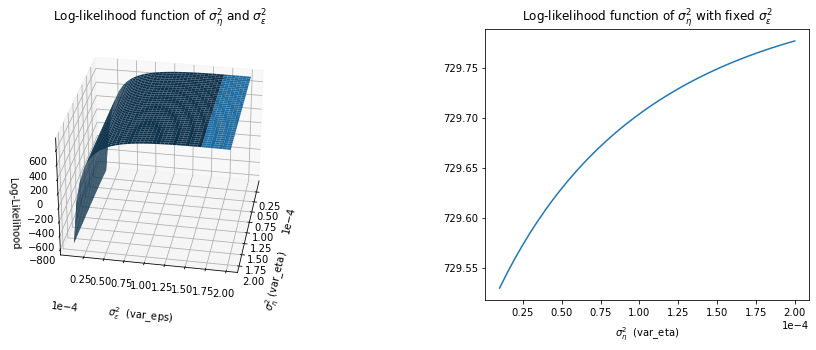

In [132]:
fig = plt.figure(figsize=(16,5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3,2])
ax = fig.add_subplot(gs[0], projection='3d'); ax2 = fig.add_subplot(gs[1])
ax.plot_surface(Y_grid, X_grid, V_grid) #, cmap=cm.ocean
ax.set_title("Log-likelihood function of $\sigma_{\eta}^2$ and $\sigma_{\epsilon}^2$")
ax.set_xlabel("$\sigma_{\eta}^2$ (var_eta)                    ", labelpad=9); 
ax.set_ylabel("$\sigma_{\epsilon}^2$  (var_eps)", labelpad=13); ax.set_zlabel("Log-Likelihood", labelpad=7); 
ax.view_init(30, 10) # this function rotates the 3d plot
ax.ticklabel_format(axis="x", style="sci", scilimits=(-4,2))
ax.ticklabel_format(axis="y", style="sci", scilimits=(-4,2))
ax2.plot(var_eta_y, V)
ax2.set_title("Log-likelihood function of $\sigma_{\eta}^2$ with fixed $\sigma_{\epsilon}^2$")
ax2.set_xlabel("$\sigma_{\eta}^2$  (var_eta)", labelpad=8)
ax2.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.show()

In [133]:
KR.calibrate_MLE()

print("beta_last = ", KR.betas[-1], "P_last = ", KR.Ps[-1])
print("var_eta_MLE = ", KR.var_eta, "var_eps_MLE = ", KR.var_eps, "var_eps_OLS = ", var_eps_ols)

KR.run(ret_test[X], ret_test[Y])

Optimization converged successfully
var_eps = 0.00016390306508927364, var_eta = 0.0004354479081641543
beta_last =  0.7096753426449268 P_last =  0.027921982129054373
var_eta_MLE =  0.0004354479081641543 var_eps_MLE =  0.00016390306508927364 var_eps_OLS =  0.00016690670965124833


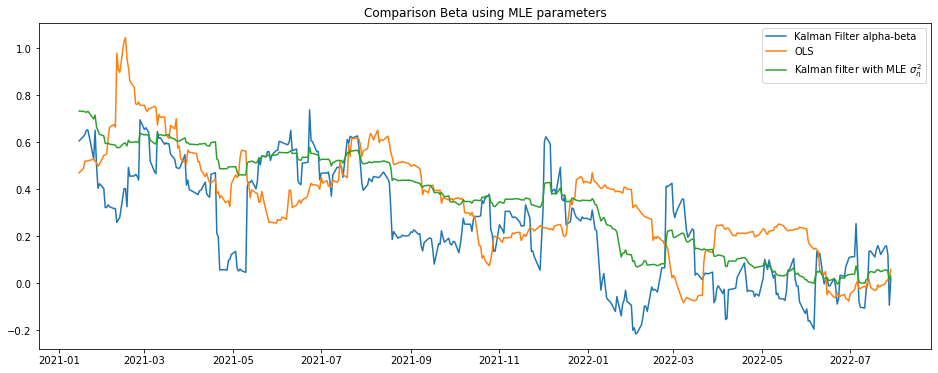

In [134]:
plt.figure(figsize=(16,6))
plt.plot( ret_test.index, betas, label="Kalman Filter alpha-beta")
plt.plot( ret_test["ols_beta"], label="OLS" )
plt.plot(ret_test.index, KR.betas, label="Kalman filter with MLE $\sigma_{\eta}^2$")
plt.legend(); plt.title("Comparison Beta using MLE parameters"); plt.show()